In [44]:
import pandas as pd
import mappy as mp
import os
import sys
import random
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
ref_path = "/nfs/turbo/umms-indikar/shared/projects/poreC/data/references/fasta/Mus_musculus.GRCm39.dna.chromosome.19.fa"
cutter = "CATG"

aligner = mp.Aligner(ref_path, preset='map-ont', n_threads=10)
print(aligner.seq_names)

# extract the reference sequence
ref_sequence = aligner.seq("19")
print(f"{len(ref_sequence)=}")

# get all cut sites
sites=[m.start() for m in re.finditer(cutter, ref_sequence)]
print(f"{len(sites)=}")
sites[:10]

['19']
len(ref_sequence)=61420004
len(sites)=282068


[3050012,
 3050435,
 3050653,
 3050956,
 3051394,
 3051547,
 3051728,
 3051849,
 3052134,
 3052154]

In [33]:
# generate a sinlge n-bp sequence from the reference
# start_idx = np.random.choice(range(len(sites)), 1)[0]
start_idx = 278469
end_idx = start_idx + 1
start = sites[start_idx]
end = sites[end_idx]
seq = ref_sequence[start:end]

print(f"Restriction Site: {start_idx}, {len(seq)}bp, {start}:{end}")

Restriction Site: 278469, 864bp, 60602782:60603646


In [34]:
seq[:10]

'CATGACACAC'

In [43]:
def mutate(sequence, n_modifications):
    """
    Modifies a genomic sequence by making n random base modifications.

    Args:
        sequence (str): The genomic sequence to modify.
        n_modifications (int): The number of modifications to make.

    Returns:
        str: The modified sequence.
    """
    bases = "ACGT"  # Standard DNA bases
    sequence = list(sequence)  # Make the sequence mutable

    for _ in range(n_modifications):
        position = random.randrange(len(sequence))
        modification_type = random.choice(["swap", "insert", "delete"])

        if modification_type == "swap":
            sequence[position] = random.choice(bases)
        elif modification_type == "insert":
            sequence.insert(position, random.choice(bases))
        else:  # Delete
            del sequence[position]

    return "".join(sequence)  # Convert back to a string

In [60]:
results = []

n_trials = 100
n_steps = 500
bp_modifications = np.linspace(0, len(seq), n_steps).astype(int)

for t in range(n_trials):
    for n_bp in bp_modifications:
        new_seq = mutate(seq, n_bp)

        for hit in aligner.map(new_seq): 

            row = {
                'trial' : t,
                'n_modifications' : n_bp,
                'percent_original_modified' : n_bp / len(seq),
                'modified_seq_len' : len(new_seq),
                'ref_name' : hit.ctg,
                'start_position_offset' : np.abs(hit.r_st - start),
                'end_position_offset' : np.abs(hit.r_en - end),
                'mapq' : hit.mapq,
                'n_matching' : hit.mlen,
                'n_mismatch' : hit.NM,
            }
            results.append(row)
    
results = pd.DataFrame(results)
results.head()

,trial,n_modifications,percent_original_modified,modified_seq_len,ref_name,start_position_offset,end_position_offset,mapq,n_matching,n_mismatch
0,0,0,0.000000,864,19,0,0,60,864,0
1,0,1,0.001157,864,19,0,0,60,863,1
2,0,3,0.003472,865,19,0,0,60,862,3
3,0,5,0.005787,864,19,0,0,60,861,5
4,0,6,0.006944,865,19,0,0,60,861,6


Text(0.5, 0, 'N Bases Modified')

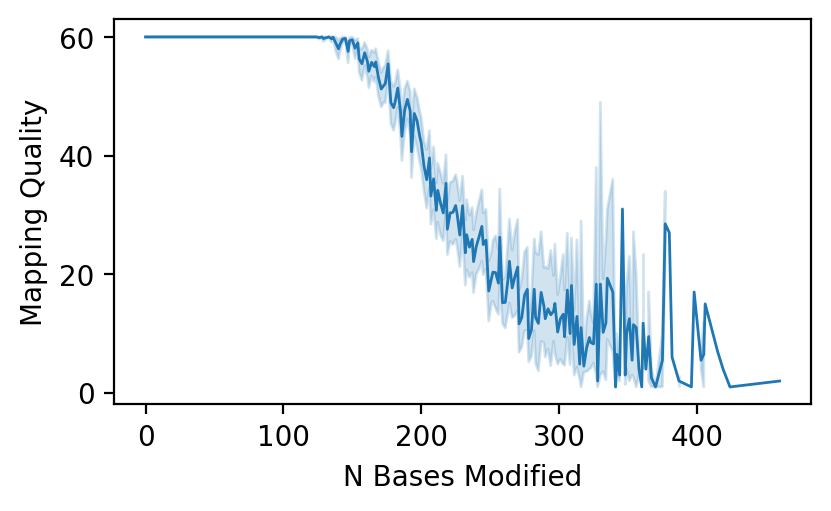

In [66]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4.5, 2.5

sns.lineplot(data=results, 
             x='n_modifications',
             y='mapq',
             lw=1,
            )

plt.ylabel('Mapping Quality')
plt.xlabel('N Bases Modified')

Text(0.5, 0, 'N Bases Modified')

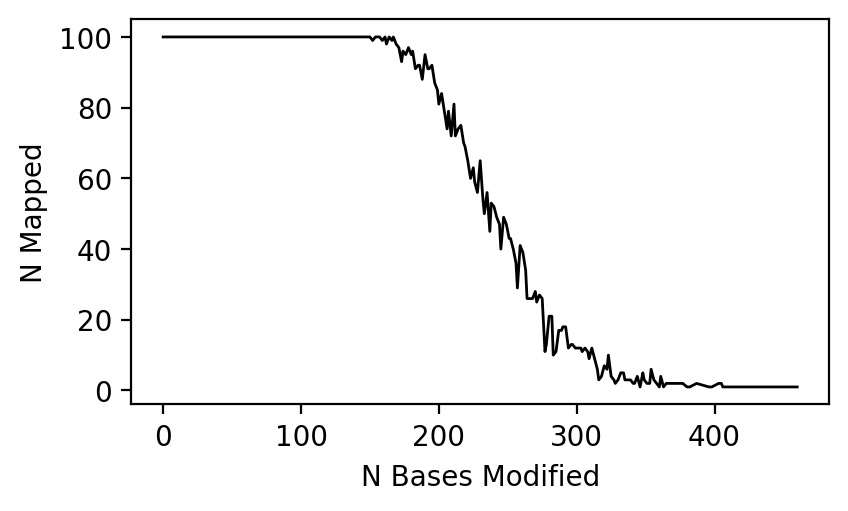

In [74]:
gx = results.groupby('n_modifications')['trial'].nunique().reset_index()

sns.lineplot(data=gx, 
             x='n_modifications',
             y='trial',
             lw=1,
             color='k',
            )

plt.ylabel('N Mapped')
plt.xlabel('N Bases Modified')

<Axes: xlabel='start_position_offset', ylabel='Count'>

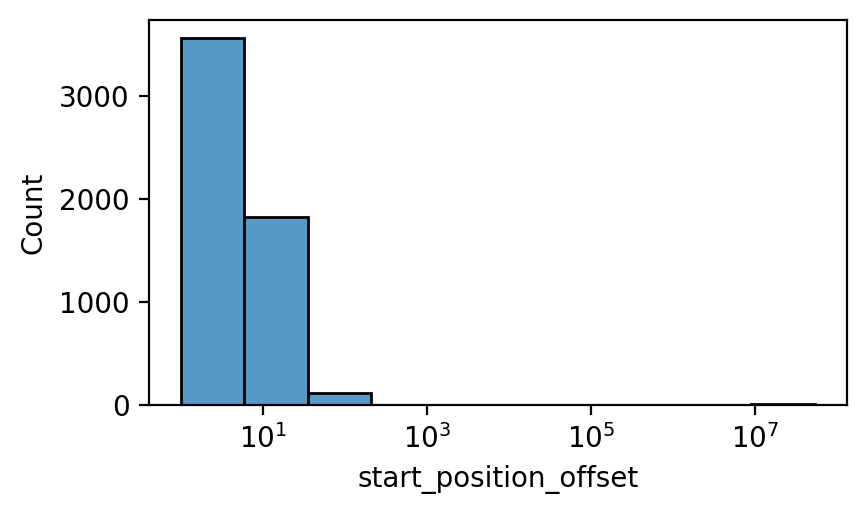

In [77]:
sns.histplot(data=results,
             x='start_position_offset',
             log_scale=True,
             bins=10)